In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [2]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

c1nc[nH]n1  c1c[nH]cn1  c1cc[nH]c1  c1ccncc1  c1ccc2[nH]ccc2c1  \
0            0           0           0         0                 0   
1            0           0           0         0                 0   
2            0           0           0         0                 0   
3            0           0           0         0                 0   
4            0           0           0         0                 0   
..         ...         ...         ...       ...               ...   
77           0           0           0         0                 0   
78           0           0           0         0                 0   
79           0           0           0         0                 0   
80           0           0           0         0                 0   
81           0           0           0         0                 0   

    c1ccc2scnc2c1  c1ccc2cc3ccccc3cc2c1  c1cscn1  c1ccsc1  c1cn[nH]c1  \
0               0                     0        0        1           0   
1               0                     0        0        1           0   
2               0                     0        0        0           0   
3               0                     0        0        0           0   
4               0                     0        0        0           0   
..            ...                   ...      ...      ...         ...   
77              0                     0        0        0           0   
78              0                     0        0        0           0   
79              0                     0        0        0           0   
80              0                     0        0        0           0   
81              0                     0        0        0           0   

    c1ccc2occcc2c1  c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2  c1ccccc1  \
0                0                                     0         0   
1                0                                     0         0   
2                0                                     0         0   
3                0                                     0         0   
4                0                                     0         0   
..             ...                                   ...       ...   
77               0                                     0         0   
78               0                                     0         0   
79               0                                     0         0   
80               0                                     0         0   
81               0                                     0         0   

    c1nnn[nH]1  c1ccc2sc[n+]c2c1  c1ccc2ncccc2c1  c1nncs1  Alkene  \
0            0                 0               0        0       0   
1            0                 0               0        0       0   
2            0                 0               0        0       0   
3            0                 0               0        0       0   
4            0                 0               0        0       2   
..         ...               ...             ...      ...     ...   
77           0                 0               0        0       0   
78           0                 0               0        0       0   
79           0                 0               0        0       0   
80           0                 0               0        0       0   
81           0                 0               0        0       0   

    Alkylchloride  Alkylfluoride  Alkylbromide  Trifluoromethyl  Alcohol  \
0               0              0             0                0        0   
1               0              0             0                0        0   
2               0              0             0                0        0   
3               0              0             0                0        0   
4               0              0             0                0        0   
..            ...            ...           ...              ...      ...   
77              0              0             0                0        0   
78      

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[4])
y_data

FE formate
0     7.257787
1     2.081697
2    12.348173
3     3.004140
4     5.017220
..         ...
77    2.400569
78    3.491043
79    2.594404
80    4.349028
81    4.823718

[82 rows x 1 columns]

In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [8]:
selected

[299,
 3,
 305,
 300,
 227,
 158,
 244,
 237,
 220,
 100,
 175,
 8,
 234,
 38,
 302,
 75,
 226,
 243,
 45,
 107,
 127,
 146,
 196,
 61,
 304,
 238,
 31,
 89,
 108,
 97,
 247,
 212,
 210,
 65,
 63,
 193,
 64,
 268,
 116,
 57,
 113,
 303,
 174,
 19,
 229,
 25,
 21,
 180,
 5,
 10,
 215,
 183,
 262,
 44,
 55,
 0,
 1,
 2,
 4,
 6,
 9,
 99,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 95,
 41,
 43,
 47,
 17,
 53,
 56,
 60,
 62,
 110,
 240,
 249,
 46,
 14,
 256,
 109,
 135,
 111,
 257,
 270,
 301,
 157,
 160,
 201,
 130,
 71,
 206,
 242,
 251,
 241,
 250,
 293,
 49,
 139,
 119,
 98,
 59,
 27,
 121,
 246,
 58,
 177,
 73,
 118,
 22,
 23,
 161,
 245,
 295,
 141,
 198,
 137,
 124,
 195,
 129,
 258,
 216,
 213,
 159,
 138,
 248,
 204,
 219,
 123,
 51,
 207,
 225,
 96,
 269,
 211,
 194,
 275,
 239,
 259,
 285,
 74,
 134,
 122,
 148,
 152,
 217,
 179,
 271,
 92,
 189,
 205,
 42,
 101,
 128,
 231,
 221,
 120,
 230,
 267,
 214,
 228,
 222,
 32,
 114,
 29,
 162,
 91,
 232,
 255,
 19

In [9]:
train_mse_list

[0.029596382786293396,
 0.022531853632922247,
 0.019984264449007957,
 0.01936525016236549,
 0.014750545815516044,
 0.008462212498787838,
 0.008051525933142996,
 0.008123244398273064,
 0.008019302477207422,
 0.008040502986586977,
 0.007861367381572022,
 0.007827430152308364,
 0.007900015900239211,
 0.007930211012525815,
 0.007796355151581742,
 0.007412550115652795,
 0.007537502921747642,
 0.007605209040210022,
 0.007719974531604515,
 0.007344036280448806,
 0.007384159204913492,
 0.007297875610648716,
 0.00683959264531246,
 0.006856070842411166,
 0.006848998233877494,
 0.006978721888442956,
 0.007137410492403015,
 0.007280242270284787,
 0.00723941971448457,
 0.007246446129967871,
 0.00718138083573696,
 0.007136946053414575,
 0.007169775508585716,
 0.007095163693593663,
 0.007036165869326594,
 0.007018521919317053,
 0.007019729010695289,
 0.007115146968272874,
 0.007149670167504216,
 0.0071606445915782385,
 0.007199109531119223,
 0.007005197569467743,
 0.006953188529726021,
 0.00695499461

In [10]:
val_mse_list

[0.035181566134219,
 0.026550470677251182,
 0.024850383916505944,
 0.024234170762619724,
 0.022597483477602428,
 0.021078765747669957,
 0.019754870578880146,
 0.018463144019535315,
 0.01796885592746551,
 0.017622442348146406,
 0.017237487177678597,
 0.01650833757088844,
 0.01637562390254232,
 0.01634969705276095,
 0.0163850837426938,
 0.016277094978436064,
 0.01618663558257878,
 0.016129516095194567,
 0.016136808018868975,
 0.016167755578437203,
 0.0158770593572145,
 0.01566672698030218,
 0.01537191354147629,
 0.01536085602242147,
 0.01539023135501738,
 0.015392417399474709,
 0.015356099582923425,
 0.015134255639994997,
 0.01500252901847681,
 0.014974690951396055,
 0.014981751309434613,
 0.014873937858908576,
 0.014760564052004013,
 0.01449857177082417,
 0.014250668545433534,
 0.014171152892200167,
 0.01419850681040678,
 0.014214829296610595,
 0.014226400433533362,
 0.014230130889258952,
 0.014248917940567114,
 0.014204764773146838,
 0.014222477045076305,
 0.014244493272620794,
 0.0142

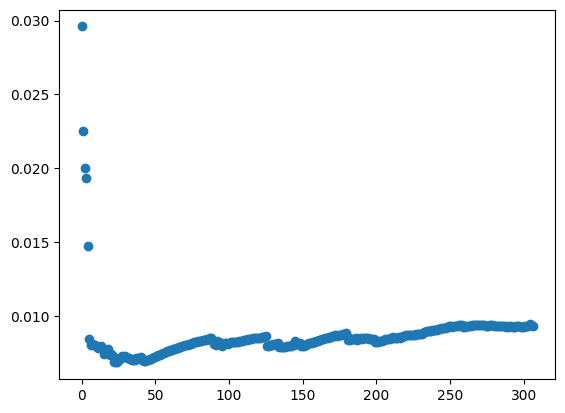

In [11]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

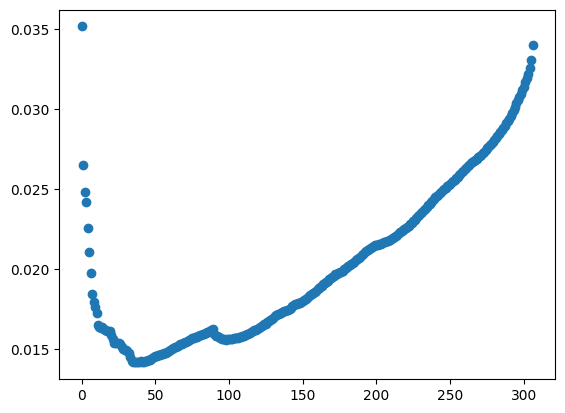

In [12]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:
val_mse_list = [0.035181566134219,
 0.026550470677251182,
 0.024850383916505944,
 0.024234170762619724,
 0.022597483477602428,
 0.021078765747669957,
 0.019754870578880146,
 0.018463144019535315,
 0.01796885592746551,
 0.017622442348146406,
 0.017237487177678597,
 0.01650833757088844,
 0.01637562390254232,
 0.01634969705276095,
 0.0163850837426938,
 0.016277094978436064,
 0.01618663558257878,
 0.016129516095194567,
 0.016136808018868975,
 0.016167755578437203,
 0.0158770593572145,
 0.01566672698030218,
 0.01537191354147629,
 0.01536085602242147,
 0.01539023135501738,
 0.015392417399474709,
 0.015356099582923425,
 0.015134255639994997,
 0.01500252901847681,
 0.014974690951396055,
 0.014981751309434613,
 0.014873937858908576,
 0.014760564052004013,
 0.01449857177082417,
 0.014250668545433534,
 0.014171152892200167,
 0.01419850681040678,
 0.014214829296610595,
 0.014226400433533362,
 0.014230130889258952,
 0.014248917940567114,
 0.014204764773146838,
 0.014222477045076305,
 0.014244493272620794,
 0.014271436813918074,
 0.014296411680330934,
 0.01433353375652717,
 0.014397314795254607,
 0.014445289859649615,
 0.014506554011064649,
 0.01455440749937792,
 0.014578287609960406,
 0.014611946902485958,
 0.014645876171798178,
 0.014686766244719481,
 0.014723999650577083,
 0.014751981459337838,
 0.01479247405146194,
 0.014836106643111763,
 0.014892337250770707,
 0.014959197166835145,
 0.015011286203319579,
 0.015076219996446543,
 0.015119143901423594,
 0.015169738708476769,
 0.015222388759221153,
 0.015269232372311472,
 0.015315427248241123,
 0.015348031864815096,
 0.015403630016634001,
 0.015444791931320454,
 0.015481347293376076,
 0.015537525613318994,
 0.015588991393848983,
 0.015635702879524475,
 0.015686604970100826,
 0.015717806189466024,
 0.015757886088345406,
 0.015788865263392023,
 0.0158340988480686,
 0.015878243993094447,
 0.0159067845835467,
 0.015934318311259583,
 0.015972626306562883,
 0.01600977129638849,
 0.016049252934002528,
 0.016095859571480447,
 0.016151150011071303,
 0.016205938770583895,
 0.0162658317343839,
 0.015965336004356782,
 0.01583453068797054,
 0.01580552176293742,
 0.015746953147691194,
 0.015674944261423372,
 0.01566339214700726,
 0.015655069233979586,
 0.015616527310709371,
 0.015607127516038719,
 0.015622659401125491,
 0.01563962651907926,
 0.015654157963138928,
 0.015660233609774397,
 0.01567685062219249,
 0.015693575109245548,
 0.015701048671716906,
 0.015721533757907184,
 0.01573975632845548,
 0.015776468756239354,
 0.015809894533695613,
 0.015851009186785375,
 0.015887071571398684,
 0.01592071765269609,
 0.015965782173550075,
 0.01601538965248326,
 0.01606764777420501,
 0.01611532796451266,
 0.01617778404336268,
 0.016228533231551902,
 0.016277168913720594,
 0.016333112400973016,
 0.016385911634225325,
 0.01643600548095544,
 0.01650011379781218,
 0.016553391324079073,
 0.01660630645078068,
 0.016680187442775486,
 0.01673581762212723,
 0.01681103105723538,
 0.016888561486326087,
 0.01697544658346866,
 0.017054944342978662,
 0.017126942960836326,
 0.01718421417275083,
 0.017228194068910307,
 0.017276169497280218,
 0.017326421961888924,
 0.017372168495294972,
 0.01740081392826833,
 0.0174316268871649,
 0.017477075298310912,
 0.01752602325063053,
 0.017602057050546502,
 0.017686499149814836,
 0.017767599435405228,
 0.017813958798466166,
 0.01782819460360889,
 0.017867751438293236,
 0.017921401226856738,
 0.017976660121327277,
 0.01803159214850686,
 0.018088620031189523,
 0.018166536123895984,
 0.01823365470571302,
 0.018301176526092127,
 0.018383889190413533,
 0.018468381611283533,
 0.01850423964476578,
 0.01857534150099239,
 0.018656029191989092,
 0.018742273716392192,
 0.018822143519565276,
 0.018893681632364875,
 0.018983315471126538,
 0.019052128773601434,
 0.019131846140799103,
 0.019222840267632244,
 0.019293645752584212,
 0.019362118141382275,
 0.0194414481453724,
 0.019509989637833954,
 0.019591481148327917,
 0.01967467885314263,
 0.01971733296680081,
 0.01975065811579938,
 0.019802414544888663,
 0.019849402463278883,
 0.019917790523623698,
 0.019995368495436823,
 0.02005679285870536,
 0.020142768353623636,
 0.02019287471625931,
 0.02026234054171983,
 0.020332356044765867,
 0.020408469450935676,
 0.020477539503947463,
 0.02055318990179066,
 0.020617426929773485,
 0.020715851589396893,
 0.020791282262375324,
 0.02087399355681363,
 0.020967327190702288,
 0.021054934128101492,
 0.0211466464890591,
 0.021223038798272316,
 0.021264009681571838,
 0.021313774513418655,
 0.021382449202992135,
 0.021460358983552693,
 0.021504152804778805,
 0.021487351151448952,
 0.021512883011268663,
 0.021550464006568504,
 0.02159407784706302,
 0.021642799767968676,
 0.021686852448748423,
 0.021706526043582954,
 0.02174414944672374,
 0.021793012179873145,
 0.021843541223210625,
 0.021898611873211238,
 0.021963088509540256,
 0.02202204475011606,
 0.022085560927574802,
 0.022161080990461674,
 0.022247057444517146,
 0.02232640820133052,
 0.022393024620106967,
 0.02246993144795955,
 0.022532983981672666,
 0.022576863954011782,
 0.022646753705971308,
 0.02272435008680889,
 0.022819191243110194,
 0.02292178714169365,
 0.023014153454036422,
 0.02311017879153395,
 0.0232005542364109,
 0.023301843309673966,
 0.023388575309336912,
 0.023498826446128423,
 0.023589006824167463,
 0.023693185268519667,
 0.02379450631873331,
 0.02390029949154846,
 0.023996061279611344,
 0.02409156021171688,
 0.024195185123014967,
 0.024293223346641853,
 0.024405219412967933,
 0.024496798179878786,
 0.02457977167103866,
 0.024673595203471815,
 0.024763684272088388,
 0.02485532817990046,
 0.024941757625087328,
 0.025040585608623656,
 0.025108848430118097,
 0.025193170857992737,
 0.02527497014845771,
 0.025362592120606937,
 0.02543389690915513,
 0.02552032780721537,
 0.025604213780762487,
 0.025690578711910623,
 0.02577898630120351,
 0.025879702740481562,
 0.02597411990902897,
 0.026066456205558135,
 0.026158513043932748,
 0.02625093466148094,
 0.026344457730384362,
 0.02643118946016689,
 0.02652272552350171,
 0.026614318604145815,
 0.026691060142213546,
 0.026771003987991555,
 0.02685734758228367,
 0.026921019840928363,
 0.02699292625425309,
 0.027065139621351743,
 0.02714922105433005,
 0.027243505758117008,
 0.027352567932231925,
 0.027454743345580495,
 0.02755767878306754,
 0.027656353845339036,
 0.02775521483857892,
 0.027847154908611237,
 0.027957713748541103,
 0.028080054189299968,
 0.028204308987189154,
 0.028324334082415203,
 0.0284592411382385,
 0.028583311677933803,
 0.028713919972441864,
 0.028843218914030334,
 0.028981932305199222,
 0.02911747060075105,
 0.029269688034470564,
 0.029419368678423964,
 0.029593450793028588,
 0.029779538486560526,
 0.029956512905640338,
 0.03017010668503779,
 0.03036742088890022,
 0.03058031384734177,
 0.03077854081450303,
 0.030959626859426347,
 0.031180056596679724,
 0.03142064050206306,
 0.03168483808789238,
 0.03193461234767238,
 0.03220810015769393,
 0.03261189115780121,
 0.03311552339437332,
 0.034049684946641456]

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

35
0.014171152892200167


In [9]:
selected = [299,
 3,
 305,
 300,
 227,
 158,
 244,
 237,
 220,
 100,
 175,
 8,
 234,
 38,
 302,
 75,
 226,
 243,
 45,
 107,
 127,
 146,
 196,
 61,
 304,
 238,
 31,
 89,
 108,
 97,
 247,
 212,
 210,
 65,
 63,
 193,
 64,
 268,
 116,
 57,
 113,
 303,
 174,
 19,
 229,
 25,
 21,
 180,
 5,
 10,
 215,
 183,
 262,
 44,
 55,
 0,
 1,
 2,
 4,
 6,
 9,
 99,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 95,
 41,
 43,
 47,
 17,
 53,
 56,
 60,
 62,
 110,
 240,
 249,
 46,
 14,
 256,
 109,
 135,
 111,
 257,
 270,
 301,
 157,
 160,
 201,
 130,
 71,
 206,
 242,
 251,
 241,
 250,
 293,
 49,
 139,
 119,
 98,
 59,
 27,
 121,
 246,
 58,
 177,
 73,
 118,
 22,
 23,
 161,
 245,
 295,
 141,
 198,
 137,
 124,
 195,
 129,
 258,
 216,
 213,
 159,
 138,
 248,
 204,
 219,
 123,
 51,
 207,
 225,
 96,
 269,
 211,
 194,
 275,
 239,
 259,
 285,
 74,
 134,
 122,
 148,
 152,
 217,
 179,
 271,
 92,
 189,
 205,
 42,
 101,
 128,
 231,
 221,
 120,
 230,
 267,
 214,
 228,
 222,
 32,
 114,
 29,
 162,
 91,
 232,
 255,
 192,
 170,
 145,
 291,
 94,
 164,
 218,
 140,
 173,
 263,
 72,
 76,
 142,
 102,
 103,
 154,
 236,
 50,
 126,
 294,
 273,
 284,
 188,
 117,
 274,
 34,
 279,
 197,
 191,
 52,
 187,
 84,
 190,
 280,
 184,
 186,
 151,
 54,
 66,
 167,
 172,
 24,
 181,
 185,
 288,
 252,
 282,
 223,
 68,
 143,
 208,
 131,
 209,
 144,
 90,
 276,
 203,
 69,
 289,
 202,
 77,
 254,
 67,
 277,
 70,
 86,
 78,
 171,
 283,
 281,
 82,
 253,
 260,
 298,
 199,
 81,
 79,
 296,
 278,
 290,
 115,
 150,
 297,
 235,
 80,
 200,
 155,
 153,
 147,
 165,
 163,
 112,
 93,
 286,
 83,
 169,
 168,
 182,
 233,
 224,
 136,
 261,
 125,
 106,
 85,
 88,
 166,
 176,
 272,
 306,
 87,
 292,
 104,
 105,
 133,
 28,
 265,
 149,
 266,
 30,
 264,
 7,
 156,
 12,
 287,
 48,
 132,
 178]

#for i in selected[:18]:
    #j = sorted_index[i]
   # print('{}'.format(x_train.columns[j]))

In [10]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Atom1_ESP All area (Ang^2)
c1ccncc1
Atom1_ALIE Max value
Atom1_ESP Minimal value (kcal/mol)
Mid-Fun_MR_Max
NumAromaticRings
Conju_LogP_Max
Conju_PEOE-Charge_Mean
Mid-Fun_LogP_Mean
PEOE_VSA2
Conju-Part-Wt (Max-Conju)
c1ccsc1
Conju_PEOE-Charge_Sum
Thioacetal
Atom1_ESP All average (kcal/mol)
BalabanJ
Mid-Fun_LogP_Max
Conju_PEOE-Charge_Max
Amide
PEOE_VSA9
SlogP_VSA8
VSA_EState7
Atom_LogP_Delta
Tri_boron
Atom1_ALIE Min value
Conju_LogP_Mean
Dialkylthioether
HallKierAlpha
SMR_VSA1
PEOE_VSA12
Conju_LogP_Min
Fun_MR_Min
Fun_PEOE-Charge_Min
MinAbsEStateIndex
MaxAbsEStateIndex
Atom_LogP_Min


In [20]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
import os
# 指定图像保存的路径
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-formate.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

Atom1_ESP All area (Ang^2)  c1ccncc1  Atom1_ALIE Max value  \
0                     16.87092         0             15.596793   
1                     17.21584         0             15.107320   
2                     13.47059         0             14.326353   
3                     16.36156         0             14.612181   
4                     16.81620         0             13.237998   
..                         ...       ...                   ...   
77                    15.75442         0             14.221609   
78                    15.77360         0             14.306894   
79                    15.79733         0             14.519096   
80                    15.79664         0             14.338035   
81                    15.87011         0             14.691888   

    Atom1_ESP Minimal value (kcal/mol)  Mid-Fun_MR_Max  NumAromaticRings  \
0                            16.841987         34.0375                 1   
1                             0.743094         32.0190                 1   
2                            -7.521853          8.9860                 0   
3                           -13.944614         15.1820                 0   
4                           -37.500848         10.1970                 0   
..                                 ...             ...               ...   
77                          -33.995517          8.9860                 0   
78                          -33.510114          8.9860                 0   
79                          -32.282694          8.9860                 0   
80                          -30.906308          8.9860                 0   
81                          -27.252022          8.9860                 0   

    Conju_LogP_Max  Conju_PEOE-Charge_Mean  Mid-Fun_LogP_Mean  PEOE_VSA2  \
0           0.6122           -1.259678e-01           0.413467   4.794537   
1           2.5106           -4.160000e-17           2.510600   0.000000   
2          -0.4222           -1.231819e-01          -0.020850   4.794537   
3          -0.4222           -1.337200e-01           0.150667   9.589074   
4           0.6792           -1.928926e-02           0.679200   0.000000   
..             ...                     ...                ...        ...   
77          0.0000            0.000000e+00           0.380500   0.000000   
78          0.0000            0.000000e+00           0.380500   0.000000   
79          0.0000            0.000000e+00           0.380500   0.000000   
80          0.0000            0.000000e+00           0.380500   0.000000   
81          0.0000            0.000000e+00           0.380500   0.000000   

    Conju-Part-Wt (Max-Conju)  c1ccsc1  Conju_PEOE-Charge_Sum  Thioacetal  \
0                     108.121        1          -1.259678e-01           0   
1                     160.015        1          -4.160000e-17           0   
2                      44.009        0          -1.231819e-01           0   
3                      44.009        0          -2.674400e-01           0   
4                      24.022        0          -3.857851e-02           0   
..                        ...      ...                    ...         ...   
77                      0.000        0           0.000000e+00           0   
78                      0.000        0           0.000000e+00           0   
79                      0.000        0           0.000000e+00           0   
80                      0.000        0           0.000000e+00           0   
81                      0.000        0           0.000000e+00           0   

    Atom1_ESP All average (kcal/mol)  BalabanJ  Mid-Fun_LogP_Max  \
0                           39.01412  2.903362            0.6122   
1                           20.66318  3.049648            2.5106   
2                           24.20452  2.847379            0.3805   
3                           21.85000  3.007306            1.2964   
4                          -10.74523  2.679549            0.6792   
..                               ...       ...      

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-formate.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Atom1_ESP All area (Ang^2)', 'c1ccncc1', 'Atom1_ALIE Max value', 'Atom1_ESP Minimal value (kcal/mol)', 'Mid-Fun_MR_Max', 'NumAromaticRings', 'Conju_LogP_Max', 'Conju_PEOE-Charge_Mean', 'Mid-Fun_LogP_Mean', 'PEOE_VSA2', 'Conju-Part-Wt (Max-Conju)', 'c1ccsc1', 'Conju_PEOE-Charge_Sum', 'Thioacetal', 'Atom1_ESP All average (kcal/mol)', 'BalabanJ', 'Mid-Fun_LogP_Max', 'Conju_PEOE-Charge_Max', 'Amide', 'PEOE_VSA9', 'SlogP_VSA8', 'VSA_EState7', 'Atom_LogP_Delta', 'Tri_boron', 'Atom1_ALIE Min value', 'Conju_LogP_Mean', 'Dialkylthioether', 'HallKierAlpha', 'SMR_VSA1', 'PEOE_VSA12', 'Conju_LogP_Min', 'Fun_MR_Min', 'Fun_PEOE-Charge_Min', 'MinAbsEStateIndex', 'MaxAbsEStateIndex', 'Atom_LogP_Min']
Test MSE: 0.0452
Test R2: 0.3792
Results saved to 'Test mse after svr/final_evaluation-formate.csv'
